In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
from pathlib import Path
from tqdm import tqdm

## Look at the robot_state data in the raw sim data

In [ ]:
data = zarr.open("/data/scratch/ankile/furniture-data/data/processed/sim/image_small/one_leg/data.zarr", mode="r")

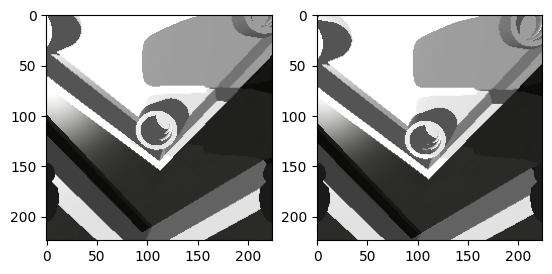

In [ ]:
img = data["color_image1"][0:2]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img[0])
ax2.imshow(img[1])

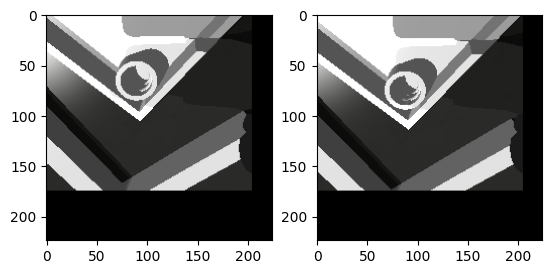

In [ ]:
def random_translate(img):
    max_translation = 50
    H, W, _ = img.shape[1:]
    translated_images = np.zeros_like(img)

    translation_height = np.random.randint(-max_translation, max_translation)
    translation_width = np.random.randint(-max_translation, max_translation)

    # Calculate the indices for zero-padded array
    start_height = max(translation_height, 0)
    end_height = H + min(translation_height, 0)
    start_width = max(translation_width, 0)
    end_width = W + min(translation_width, 0)

    # Calculate the indices for the original image
    start_height_orig = -min(translation_height, 0)
    end_height_orig = H - max(translation_height, 0)
    start_width_orig = -min(translation_width, 0)
    end_width_orig = W - max(translation_width, 0)

    # Index into the zero-padded array and place the original image
    translated_images[:, start_height:end_height, start_width:end_width, :] = img[
        :, start_height_orig:end_height_orig, start_width_orig:end_width_orig, :
    ]

    return translated_images


translated_images = random_translate(img)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(translated_images[0])
ax2.imshow(translated_images[1])

In [18]:
data["episode_ends"][:]

array([ 475,  993, 1441, 1961, 2411, 2890, 3381, 3913, 4379, 4863],
      dtype=uint32)